In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

# Predicting Diabetes Based on Key Symptoms

The dataset used for this analysis is available on Kaggle: [Early Stage Diabetes Risk Prediction](https://www.kaggle.com/datasets/abdelazizsami/early-stage-diabetes-risk-prediction). I begin by loading it into a pandas dataframe.

In [2]:
df = pd.read_csv("diabetes.csv")
train_df, test_df = train_test_split(df, random_state=111)
train_df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
367,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,Yes,No,No,Positive
145,61,Male,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Positive
258,35,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
238,72,Male,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Negative
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive


## Data Exploration

First, I want to check what the data type of each feature is, as well as check for any missing values.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 367 to 86
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 390 non-null    int64 
 1   Gender              390 non-null    object
 2   Polyuria            390 non-null    object
 3   Polydipsia          390 non-null    object
 4   sudden weight loss  390 non-null    object
 5   weakness            390 non-null    object
 6   Polyphagia          390 non-null    object
 7   Genital thrush      390 non-null    object
 8   visual blurring     390 non-null    object
 9   Itching             390 non-null    object
 10  Irritability        390 non-null    object
 11  delayed healing     390 non-null    object
 12  partial paresis     390 non-null    object
 13  muscle stiffness    390 non-null    object
 14  Alopecia            390 non-null    object
 15  Obesity             390 non-null    object
 16  class               390 non-nu

Since none of the features are missing any values, there is no need for imputation for any of the features. It looks like `Age` is a numeric feature, and everything else is a binary feature representing whether a particular symptom was observed. None of the features seem to be unique identifiers (e.g. patient IDs). For my analysis, I will be trying to predict `class` which denotes whether the individual with that particular set of symptoms was diagnosed with diabetes.

Also, it is important to check whether the distribution of the target (`class`) is highly skewed. If most of the people recorded didn't have diabetes, for example, even a poor model that always predicts a negative status could still have high accuracy, which makes the metric less useful.

In [4]:
train_df['class'].value_counts()

class
Positive    244
Negative    146
Name: count, dtype: int64

There is some skew (63% of the patients were positive for diabetes), but fortunately it doesn't seem to be severe enough to make accuracy (the default metric) unsuitable. I will proceed with accuracy as the metric for my analysis.

Before moving on, I also want to see some basic statistical information about the sole numerical feature, `Age`.

In [5]:
train_df.describe()

,Age
count,390.000000
mean,48.394872
std,12.054844
min,25.000000
25%,39.000000
50%,48.000000
75%,57.000000
max,90.000000


It looks like a lot of the patients in the dataset are relatively older than the general population, with a median age of 48 for the training dataset. Let's also take a look at the distributions for both groups.

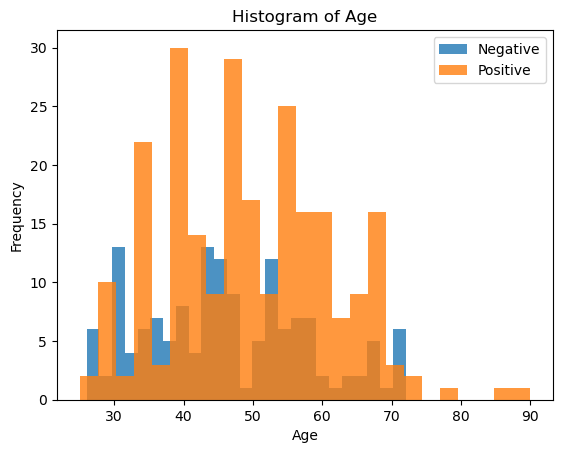

In [6]:
ax = train_df.groupby("class")["Age"].plot.hist(bins=25, alpha=0.8, legend=True)
plt.xlabel("Age")
plt.title("Histogram of Age")
plt.show()

From the distribution, it does look like there is a significant difference in the distribution for the group that tested negative for diabetes compared to the group that tested positive. This suggests that `Age` does have some sort of correlation with diabetes status, so I'll retain it as a feature.

The remaining features are all binary (gender is treated as binary in this dataset). Before proceeding with the analysis, I'll first check to see if there are also differences in diabetes status based on gender.

In [7]:
train_df["Gender"].value_counts()

Gender
Male      238
Female    152
Name: count, dtype: int64

There are significantly more men in the dataset than there are women (also a notable bias for later generalizability). Now I'll look at the breakdown based on gender and diabetes status.

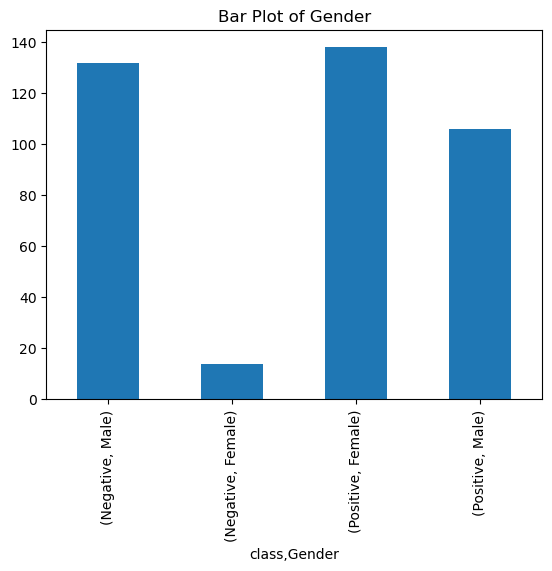

In [8]:
ax = train_df.groupby("class")["Gender"].value_counts().plot(kind='bar')
plt.title("Bar Plot of Gender")
plt.show()

Even though there were fewer total women in the dataset, more women tested positive overall than men. It looks like women in this dataset were much more likely to be positive for diabetes, which does suggest that `Gender` will be a useful feature for prediction. The remaining features are all diagnostic symptoms of diabetes and therefore have existing evidence to suggest that they will be relevant. With the relevant features determined, I will begin preprocessing the data.

## Data Preprocessing

After the exploration above, all the features included in the original dataset seem to be relevant. There is one numeric feature, `Age`, and 15 binary features. The target is `class`, which is also a binary feature representing whether patient was diagnosed with diabetes.

In [9]:
numeric_features = ["Age"]
target_column = ["class"]
binary_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(target_column)
)

To preprocess the data, I'll use `StandardScaler` on the numeric feature so that the magnitude doesn't affect the analysis (not relevant for some models). For the remaining models, I'll use the `OneHotEncoder` with `drop = "if_binary"` so that the text entries ("Yes" and "No") are replaced with a numerical representation.

In [10]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop = "if_binary"), binary_features),
)

To see what the data looks like after processing, I'll fit it here:

In [11]:
preprocessor.fit(train_df)

X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns = (numeric_features + binary_features)
)

X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns = (numeric_features + binary_features)
)

At this point, I will also use `LabelEncoder` to transform the target, `class`, from text answers to a numerical representation (necessary for certain models).

In [12]:
le = LabelEncoder()
y_train = train_df['class']
y_test = test_df['class']
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

A quick look at the processed data:

In [13]:
X_train_enc.head()

,Age,sudden weight loss,Polyphagia,visual blurring,Irritability,Obesity,Itching,partial paresis,Alopecia,delayed healing,Polyuria,muscle stiffness,Gender,Polydipsia,Genital thrush,weakness
367,-0.697284,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
145,1.046992,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
258,-1.112588,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
238,1.960660,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
517,0.797809,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


## Initial Model Selection

Below, I have included a useful helper function to store the mean score from performing cross-validation, originally from my machine learning course at UBC. It can be found within the public GitHub repo here: https://github.com/UBC-CS/cpsc330-2023W2/blob/main/hw/hw3/hw3.ipynb. It has been slightly edited to fix a warning.

In [14]:
# Helper function from CPSC330: Applied Machine Learning at UBC, available here:
# https://github.com/UBC-CS/cpsc330-2023W2/blob/main/hw/hw3/hw3.ipynb 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Baseline Model

For the baseline, I will use scikit-learn's `GaussianNB` to make an initial prediction with naive Bayes classifier. First, I'll split the dataset into the features and the target, since they'll be going into the preprocessor as part of a pipeline.

In [15]:
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]

Next, I'll grab a summary of the cross-validation scores from the `GaussianNB` classifier.

In [16]:
results = {}
gnb = make_pipeline(preprocessor, GaussianNB())
results["GaussianNB (Baseline)"] = mean_std_cross_val_scores(gnb, X_train, y_train, cv=5,return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)


With a score of 0.890, the `GaussianNB` model is doing pretty well. I'll take a quick look at the confusion matrix for the model:

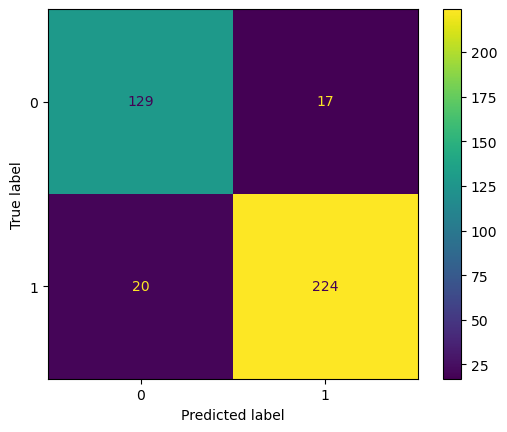

In [17]:
base = make_pipeline(preprocessor, GaussianNB())
base.fit(X_train, y_train_enc)
matrix = confusion_matrix(y_train_enc, base.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

From the confusion matrix, it doesn't look like it is having a particularly hard time with false negatives or false positives in particular. Next, I'll try some more complex models to see whether I will be able to get a better score.

### Models with Default Hyperparameters

With a baseline established, a more complex but still interpretable model is `LogisticRegression`, with its default hyperparameters. I'll be looking at its cross-validation performance again.

In [18]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=10000))
results["LogisticRegression (Default)"] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5,return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)
LogisticRegression (Default),0.009 (+/- 0.009),0.009 (+/- 0.009),0.921 (+/- 0.019),0.945 (+/- 0.008)


Another common model for classification is `RandomForest`. I'll repeat the same steps from the previous classifier, but with the `RandomForestClassifier` instead.

In [19]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))
results["RandomForest (Default)"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)
LogisticRegression (Default),0.009 (+/- 0.009),0.009 (+/- 0.009),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForest (Default),0.538 (+/- 1.023),0.024 (+/- 0.008),0.967 (+/- 0.027),1.000 (+/- 0.000)


From the cross-validation accuracy, it can be seen`RandomForestClassifier` does offer some performance improvements over both the naive Bayes classifier and `LogisticRegression`. However, it is possible that a gradient-boosted model could still do better, so I will try one more model. Again, I'll be comparing its cross-validation performance with default hyperparameters.

In [20]:
cb = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=111))
results["CatBoost (Default)"] = mean_std_cross_val_scores(cb, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)
LogisticRegression (Default),0.009 (+/- 0.009),0.009 (+/- 0.009),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForest (Default),0.538 (+/- 1.023),0.024 (+/- 0.008),0.967 (+/- 0.027),1.000 (+/- 0.000)
CatBoost (Default),1.662 (+/- 0.137),0.016 (+/- 0.000),0.967 (+/- 0.025),1.000 (+/- 0.000)


While the models all perform better than the baseline, `RandomForestClassifier` and `CatBoostClassifier` in particular are performing the best and have some overlap in cross-validation test score once accounting for the standard deviation. Notably, these two also seem to be overfitting somewhat, since they are achieving perfect scores on the training set, though this is difficult to avoid since the dataset is small. With some hyperparameter tuning, it might be possible to get a better score from them.

## Hyperparameter Tuning

Starting with `RandomForestClassifier` again, I'll use `RandomizedSearchCV` to perform a random search for the best combination of parameters. Since there are only 16 features, I'll use the full range for `max_features`. For `max_depth` I'll cover some key values in the range between 1 and 500 as well as the option to allow the trees to branch without pruning. For the number of parallel estimators, I'll also cover a range between 1 and 500, evenly spaced in tens.

In [21]:
param_dist = {
    "randomforestclassifier__max_depth": [None, 1, 5, 10, 20, 40, 80, 100, 500], 
    "randomforestclassifier__max_features": range(1, 17, 1), 
    "randomforestclassifier__n_estimators": range(1, 501, 10)  
    
}

pipe = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))

random_search = RandomizedSearchCV(pipe,  
                  random_state = 111,
                  param_distributions = param_dist, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

random_search.fit(X_train, y_train)
rf_best_score = random_search.best_score_
rf_best_params = random_search.best_params_
print(rf_best_score)
print(rf_best_params)

0.976923076923077
{'randomforestclassifier__n_estimators': 61, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 80}


Let's see how the cross-validation score stacks up.

In [22]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, 
                                                        max_depth = rf_best_params['randomforestclassifier__max_depth'],
                                                        max_features = rf_best_params["randomforestclassifier__max_features"],
                                                        n_estimators = rf_best_params["randomforestclassifier__n_estimators"]))

results["RandomForest (Tuned)"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)
LogisticRegression (Default),0.009 (+/- 0.009),0.009 (+/- 0.009),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForest (Default),0.538 (+/- 1.023),0.024 (+/- 0.008),0.967 (+/- 0.027),1.000 (+/- 0.000)
CatBoost (Default),1.662 (+/- 0.137),0.016 (+/- 0.000),0.967 (+/- 0.025),1.000 (+/- 0.000)
RandomForest (Tuned),0.069 (+/- 0.009),0.016 (+/- 0.000),0.969 (+/- 0.025),1.000 (+/- 0.000)


There seems to be a bit of a drop in performance between the score out of the randomized grid search and the cross-validation, which might be because the small dataset is being hit too many times between the cross-validation in the search and the repeated cross-validation for the comparison. Despite the drop, it's performing better than the unoptimized model.

Next, I'll attempt to get an even better score through tuning the hyperparameters for `CatBoostClassifier`. I'm choosing some values for the learning rate between 0 and 5. Also, as recommended, I'm going to look for a max depth between 4 and 10. The total number of iterations here is slightly lower than for `RandomForestClassifier` because of the extended time needed for `CatBoostClassifier` to run.

In [23]:
param_dist = {
    "catboostclassifier__learning_rate": np.linspace(0.00001,1,10),
    "catboostclassifier__max_depth": range(4, 11)
}

pipe = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=111))

random_search = RandomizedSearchCV(pipe,
                  random_state = 111,                 
                  param_distributions = param_dist, 
                  n_iter=50, 
                  return_train_score=True)

random_search.fit(X_train, y_train_enc)
cb_best_score = random_search.best_score_
cb_best_params = random_search.best_params_
print(cb_best_score)
print(cb_best_params)

0.9794871794871796
{'catboostclassifier__max_depth': 9, 'catboostclassifier__learning_rate': 0.33334}


Again, I'll compare it to the cross-validation performance of the other models.

In [24]:
cb = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, 
                                                             random_state=111, 
                                                             learning_rate = cb_best_params['catboostclassifier__learning_rate'],
                                                             max_depth = cb_best_params['catboostclassifier__max_depth']))

results["CatBoost (Tuned)"] = mean_std_cross_val_scores(cb, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

,fit_time,score_time,test_score,train_score
GaussianNB (Baseline),0.006 (+/- 0.009),0.006 (+/- 0.009),0.890 (+/- 0.027),0.900 (+/- 0.016)
LogisticRegression (Default),0.009 (+/- 0.009),0.009 (+/- 0.009),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForest (Default),0.538 (+/- 1.023),0.024 (+/- 0.008),0.967 (+/- 0.027),1.000 (+/- 0.000)
CatBoost (Default),1.662 (+/- 0.137),0.016 (+/- 0.000),0.967 (+/- 0.025),1.000 (+/- 0.000)
RandomForest (Tuned),0.069 (+/- 0.009),0.016 (+/- 0.000),0.969 (+/- 0.025),1.000 (+/- 0.000)
CatBoost (Tuned),5.338 (+/- 0.127),0.012 (+/- 0.007),0.979 (+/- 0.019),1.000 (+/- 0.000)


Out of the models tried here, it looks like the optimized version of CatBoost is performing the best, so I'll use it as my final model.

## Final Model

After determining that `CatBoostClassifier` seems to perform the best out of the models tried, I will test its performance on the test data.

In [25]:
final_model = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, 
                                                             random_state=111, 
                                                             learning_rate = cb_best_params['catboostclassifier__learning_rate'],
                                                             max_depth = cb_best_params['catboostclassifier__max_depth']))
final_model.fit(X_train, y_train_enc)
test_score = final_model.score(X_test, y_test_enc)
print(test_score)

0.9769230769230769


The test score is a little lower than the cross-validation score, which is expected. Despite not being quite as high, it is still a significant improvement over the baseline score.

## Conclusion and Limitations

The final model selected, `CatBoostClassifier` after hyperparameter optimization, was able to predict the diabetes status of the patients in the dataset with a test accuracy of 0.9769. While this is an improvement over the initial baseline model, it is possible that this score could be improved further with more feature engineering and more iterations in the randomized search for ideal hyperparameters. However, the performance does suggest that the available data is strongly related to diabetes status. 


The choice to use accuracy here meant that the scoring considered false penalties and false positives to be equally incorrect, but in some medical contexts it might be preferred to score on recall so that avoiding false negatives is most preferred. Additionally, the dataset is very small (only 390 patients), and the demographics skews towards middle-aged men. This bias in the dataset might affect how well the model would perform with a more diverse set of patients.